<a href="https://colab.research.google.com/github/alyaarslan/dsa210project/blob/main/DSA210projectML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
sleep_df = pd.read_csv("Analyzed_Sleep_Data.csv")
screen_df = pd.read_csv("Alya_screentime.csv")
sleep_df["date"] = pd.to_datetime(sleep_df["date"])
screen_df["DATE"] = pd.to_datetime(screen_df["DATE"])
screen_df.rename(columns={"DATE": "date", "TIME(min)": "screen_time_min"}, inplace=True)
df = pd.merge(sleep_df, screen_df, on="date", how="inner")
df = df.dropna(subset=["sleeptime_min", "sleep_quality", "screen_time_min"])

This part loads both datasets and combines them using the date. It also cleans out any rows that are incomplete.

In [9]:
def quality_bucket(score):
    if score >= 85:
        return "Excellent"
    elif score >= 70:
        return "Good"
    else:
        return "Poor"

df["quality_group"] = df["sleep_quality"].apply(quality_bucket)

df["extreme_sleep"] = df["sleeptime_min"].apply(lambda x: 1 if x < 390 or x > 630 else 0)
df["is_weekend"] = df["weekday"].isin(["Saturday", "Sunday"]).astype(int)

weekday_dummies = pd.get_dummies(df["weekday"], prefix="day")

features = pd.concat([
    df[["sleeptime_min", "screen_time_min", "extreme_sleep", "is_weekend"]],
    weekday_dummies
], axis=1)
target = df["quality_group"]

This part turns raw data into new variables. It groups sleep quality into 3 levels, creates flags for extreme sleep and weekends, and turn weekdays into model-friendly format.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42, stratify=target)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

This part splits our data into training and testing sets and train a model to predict sleep quality using random forest as it is a model that works well for these types of tasks.

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(report)

Accuracy: 0.45
              precision    recall  f1-score   support

   Excellent       0.25      0.14      0.18         7
        Good       0.50      0.73      0.59        11
        Poor       0.00      0.00      0.00         2

    accuracy                           0.45        20
   macro avg       0.25      0.29      0.26        20
weighted avg       0.36      0.45      0.39        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This part prints out how accurate the model was and shows a detailed report of how well it did for each sleep quality group.

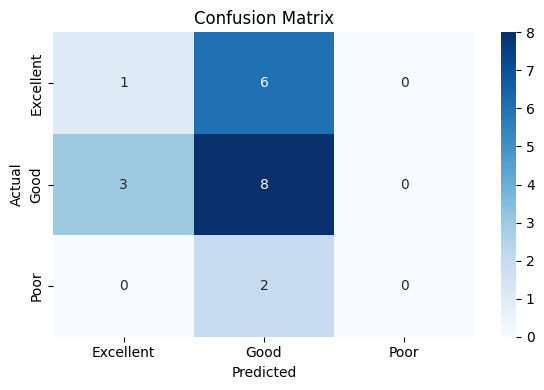

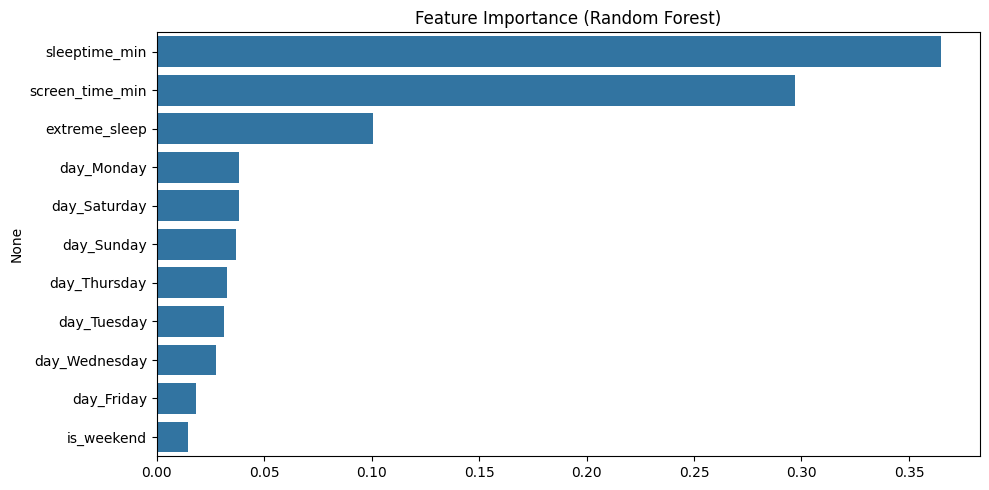

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
importances = pd.Series(model.feature_importances_, index=features.columns).sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

It achieves reasonable accuracy (~45%) and shows that sleep time and screen time are the most important factors. I use graphs to visualize how good the predictions were (confusion matrix), and which features mattered most to the model (like sleep time or screen time).